<a href="https://colab.research.google.com/github/Bernardo-Escobar/Detectar_Placa_Veicular/blob/main/Trabalho_M2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho M2

Crie um sistema para localizar os caracteres de placas veículares utilizando as imagens do dataset disponibilizado e seguindo os critérios apresentados no enunciado do trabalho.

Abaixo estão códigos auxiliares para manipulação do dataset, visualização e cálculo de métricas.

Explore este notebook antes de iniciar o trabalho para um melhor aproveitamento do seu tempo.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving dataset_completo.zip to dataset_completo (1).zip


In [ ]:
!unzip /content/drive/MyDrive/Colab_Notebooks/dataset_completo.zip -d /content/
# !unzip /content/dataset_completo.zip -d /content/

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: /content/dataset/695239.png  
  inflating: /content/dataset/695239.txt  
  inflating: /content/dataset/695327.png  
  inflating: /content/dataset/695327.txt  
  inflating: /content/dataset/695462.png  
  inflating: /content/dataset/695462.txt  
  inflating: /content/dataset/695463.png  
  inflating: /content/dataset/695463.txt  
  inflating: /content/dataset/695522.png  
  inflating: /content/dataset/695522.txt  
  inflating: /content/dataset/695568.png  
  inflating: /content/dataset/695568.txt  
  inflating: /content/dataset/695569.png  
  inflating: /content/dataset/695569.txt  
  inflating: /content/dataset/695579.png  
  inflating: /content/dataset/695579.txt  
  inflating: /content/dataset/695580.png  
  inflating: /content/dataset/695580.txt  
  inflating: /content/dataset/695581.png  
  inflating: /content/dataset/695581.txt  
  inflating: /content/dataset/695606.png  
  inflating: /content/dataset/695606.t

In [ ]:
from dataclasses import dataclass
from pathlib import Path
from typing import List, Tuple
import cv2
import matplotlib.pyplot as plt
import tqdm
import random


@dataclass
class Label:
    class_id: int
    center_y: float
    center_x: float
    height: float
    width: float


def read_label(lbl_fpath: Path):
    labels = []
    with open(lbl_fpath, "r") as f:
        lines = f.readlines()
        for line in lines:
            cid, cx, cy, w, h = line.split(" ")
            labels.append(Label(int(cid), float(cy), float(cx), float(h), float(w)))

    return labels


def draw_bboxes(
    img_rgb: cv2.Mat,
    labels: List[Label],
    color: Tuple = (0, 255, 0),
    thickness: int = 2,
) -> cv2.Mat:

    img_copy = img_rgb.copy()
    h, w, _ = img_copy.shape

    for lbl in labels:
        cx = lbl.center_x
        cy = lbl.center_y
        bw = lbl.width
        bh = lbl.height

        # Converter coordenadas YOLO (cx,cy,bw,bh) -> (x_min,y_min,x_max,y_max)
        x_min = int((cx - bw / 2) * w)
        y_min = int((cy - bh / 2) * h)
        x_max = int((cx + bw / 2) * w)
        y_max = int((cy + bh / 2) * h)

        # Desenhar a bounding box
        cv2.rectangle(img_copy, (x_min, y_min), (x_max, y_max), color, thickness)

    return img_copy

# Visualização do dataset

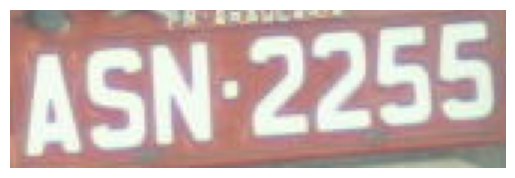

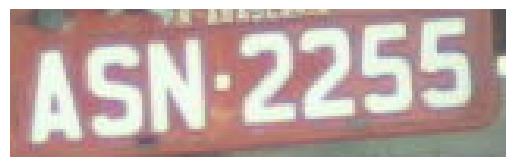

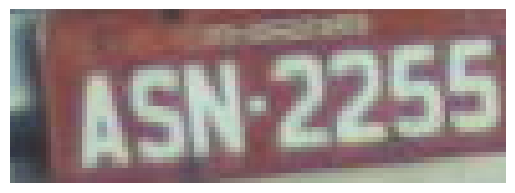

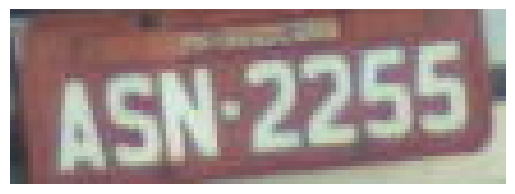

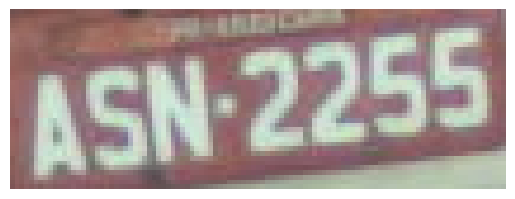

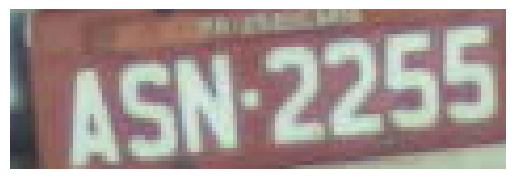

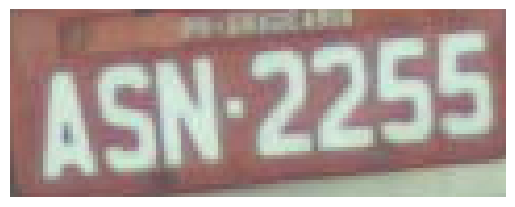

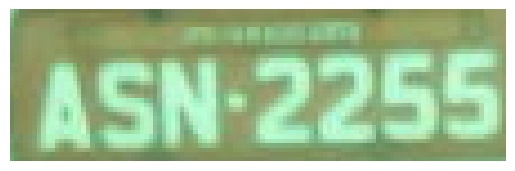

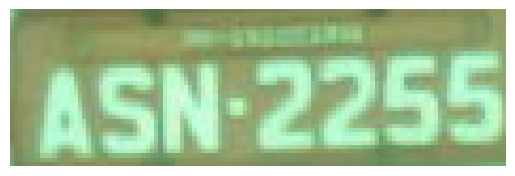

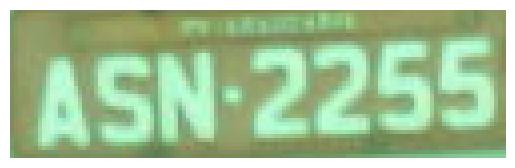

In [ ]:
dataset_dpath = Path("./dataset/")
images_fpath = list(dataset_dpath.glob("*.png"))
labels_fpath = list(dataset_dpath.glob("*.txt"))

images_fpath.sort()
labels_fpath.sort()

# display images
for img_fpath in images_fpath[0:10]:
    img_rgb = cv2.imread(img_fpath, cv2.IMREAD_COLOR_RGB)
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.show()

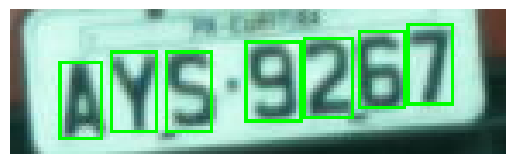

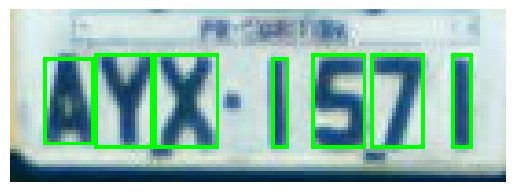

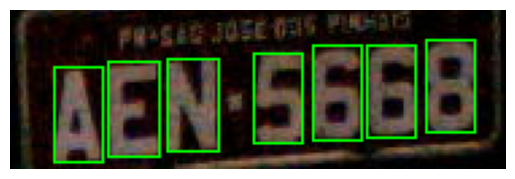

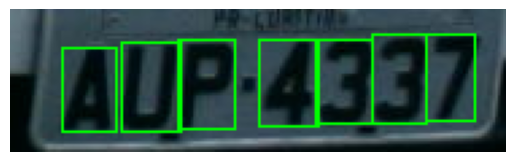

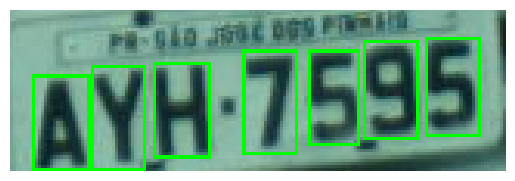

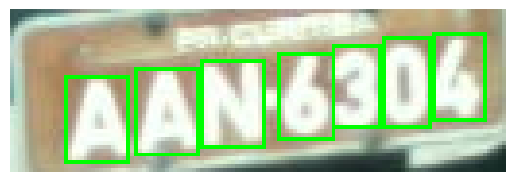

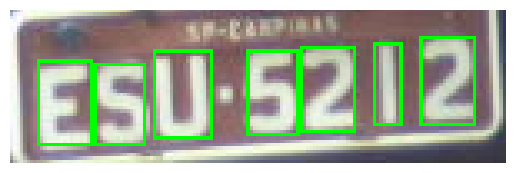

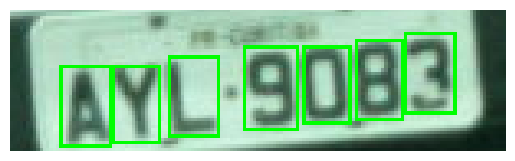

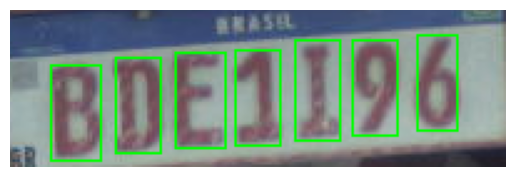

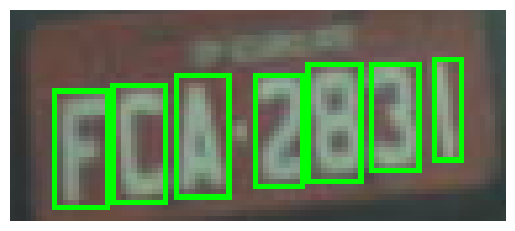

In [ ]:
# display images and labels
for img_fpath, lbl_fpath in random.sample(list(zip(images_fpath, labels_fpath)), 10):
    img_rgb = cv2.imread(img_fpath, cv2.IMREAD_COLOR_RGB)
    img_labels = read_label(lbl_fpath)
    img_with_labels = draw_bboxes(img_rgb, img_labels, thickness=1)
    plt.imshow(img_with_labels)
    plt.axis("off")
    plt.show()

# Parte principal

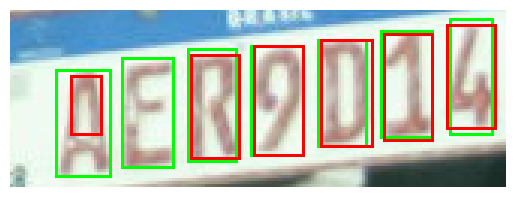

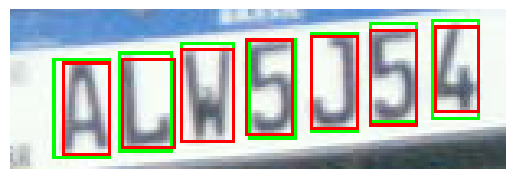

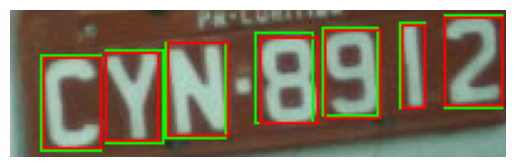

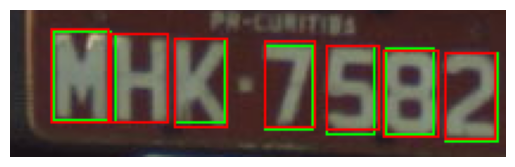

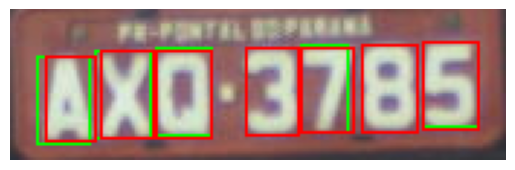

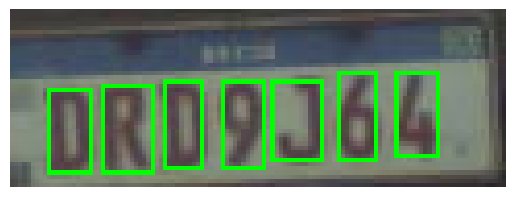

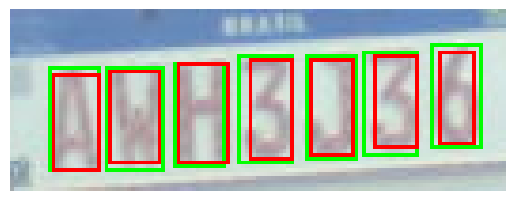

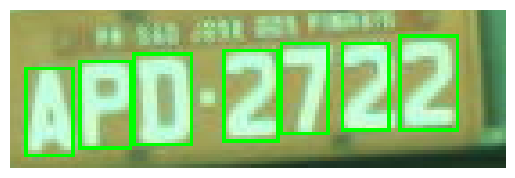

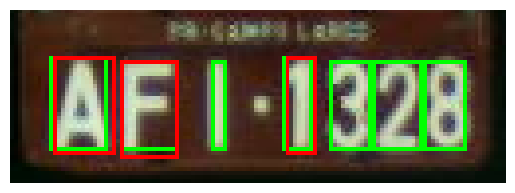

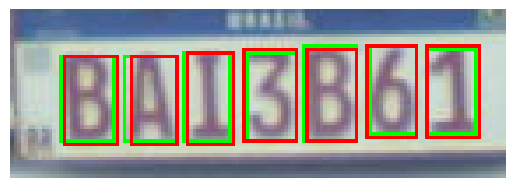

In [ ]:
import numpy as np

def localize_char_bbox(img_rgb: cv2.Mat) -> List[Label]:

    predictions: List[Label] = []

    # 1. Converter para tons de cinza
    gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

    # 2. Equalizar contraste (melhora Otsu)
    clahe = cv2.createCLAHE(clipLimit=3, tileGridSize=(8,8))
    gray_eq = clahe.apply(gray)

    # 3. Remover ruído
    blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # 4. Aplicar limiarização de Otsu
    _, otsu = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # Inverte se necessário (Verifica se há mais pixels brancos que pretos)
    if np.mean(otsu) > 127:
        otsu = cv2.bitwise_not(otsu)

    # 5. Detecção de bordas com Canny (limiares automáticos)
    v = np.median(blur)
    edges = cv2.Canny(blur, 0.7 * v, 1.2 * v)

    # 6. Combinar Otsu + Canny de forma ponderada
    combined = cv2.addWeighted(otsu, 0.55, edges, 0.45, 0)


    # 7. Encontrar contornos
    contours, _ = cv2.findContours(combined, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    h_img, w_img = gray.shape

    # 8. Ordenar da esquerda para a direita
    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0])

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)

        # 9. Filtrar contornos muito pequenos ou grandes
        if h < 10 or w < 6:
            continue
        if h > h_img * 0.9 or w > w_img * 0.9:
            continue
        # Razão de aspecto (ajustada para letras largas)
        aspect_ratio = w / float(h)
        if aspect_ratio < 0.25 or aspect_ratio > 1.0:
            continue

        # 10. Converter para coordenadas YOLO-like
        center_x = (x + w / 2) / w_img
        center_y = (y + h / 2) / h_img
        w_norm = w / w_img
        h_norm = h / h_img

        predictions.append(Label(
            class_id=0,
            center_x=center_x,
            center_y=center_y,
            width=w_norm,
            height=h_norm
        ))

    return predictions


# display images
for img_fpath, lbl_fpath in random.sample(list(zip(images_fpath, labels_fpath)), 10):
    img_rgb = cv2.imread(img_fpath, cv2.IMREAD_COLOR_RGB)
    img_labels = read_label(lbl_fpath)

    predictions = localize_char_bbox(img_rgb) # chama o método implementado

    imgdraw = draw_bboxes(img_rgb, img_labels, thickness=1)
    imgdraw = draw_bboxes(imgdraw, predictions, color=(255, 0, 0), thickness=1)
    plt.imshow(imgdraw)
    plt.axis("off")
    plt.show()

# Validação

In [ ]:
def compute_iou(bbox1, bbox2):
    # Converter para coordenadas absolutas [xmin, ymin, xmax, ymax]
    x1_min = bbox1.center_x - bbox1.width / 2
    y1_min = bbox1.center_y - bbox1.height / 2
    x1_max = bbox1.center_x + bbox1.width / 2
    y1_max = bbox1.center_y + bbox1.height / 2

    x2_min = bbox2.center_x - bbox2.width / 2
    y2_min = bbox2.center_y - bbox2.height / 2
    x2_max = bbox2.center_x + bbox2.width / 2
    y2_max = bbox2.center_y + bbox2.height / 2

    # Interseção
    inter_xmin = max(x1_min, x2_min)
    inter_ymin = max(y1_min, y2_min)
    inter_xmax = min(x1_max, x2_max)
    inter_ymax = min(y1_max, y2_max)

    inter_w = max(0, inter_xmax - inter_xmin)
    inter_h = max(0, inter_ymax - inter_ymin)
    inter_area = inter_w * inter_h

    # Áreas individuais
    area1 = (x1_max - x1_min) * (y1_max - y1_min)
    area2 = (x2_max - x2_min) * (y2_max - y2_min)

    # IoU
    union = area1 + area2 - inter_area
    return inter_area / union if union > 0 else 0


def evaluate_iou(detected_labels, true_labels, iou_threshold=0.5):
    ious = []
    matched = 0

    for det in detected_labels:
        best_iou = 0
        for gt in true_labels:
            iou = compute_iou(det, gt)
            best_iou = max(best_iou, iou)
        ious.append(best_iou)
        if best_iou >= iou_threshold:
            matched += 1

    mean_iou = np.mean(ious) if ious else 0
    precision = matched / len(detected_labels) if detected_labels else 0
    recall = matched / len(true_labels) if true_labels else 0

    return {"mean_iou": float(mean_iou), "precision": precision, "recall": recall}


# display images
mean_iou = 0
mean_precision = 0
mean_recall = 0
for img_fpath, lbl_fpath in tqdm.tqdm(list(zip(images_fpath, labels_fpath))):
    img_rgb = cv2.imread(img_fpath, cv2.IMREAD_COLOR_RGB)
    true_labels = read_label(lbl_fpath)

    pred_labels = localize_char_bbox(img_rgb)

    metrics = evaluate_iou(pred_labels, true_labels)
    mean_iou += metrics["mean_iou"]
    mean_precision += metrics["precision"]
    mean_recall += metrics["recall"]

n_samples = len(images_fpath)
print("")
print(f"Mean IoU: {mean_iou / n_samples}")
print(f"Mean precision: {mean_precision / n_samples}")
print(f"Mean recall: {mean_recall / n_samples}")

100%|██████████| 79916/79916 [02:37<00:00, 507.71it/s]


Mean IoU: 0.783987741130339
Mean precision: 0.8709882323010039
Mean recall: 0.7836817944555431


In [ ]:
print(f"Mean IoU: {mean_iou / n_samples}")
print(f"Mean precision: {mean_precision / n_samples}")
print(f"Mean recall: {mean_recall / n_samples}")

Mean IoU: 0.783987741130339
Mean precision: 0.8709882323010039
Mean recall: 0.7836817944555431


# Visualização


Gere abaixo alguns exemplos de predições do seu método e compare com as respostas esperadas e as respostas do método exemplo